In [2]:
#####################
#Learning an interval
#####################

#As a basic example of the insulin simulator task, attempt to use RJMCMC to learn how best to partition
#possible predicted values on the unit interval to match training data generated as equal increments on
#that interval. Some other experiments are presented leading up to this task.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch 

import pyro
import pyro.distributions as dist
from torch import nn
from pyro import poutine
from pyro.nn.module import PyroModule, PyroParam, PyroSample, to_pyro_module_
from pyro.infer.enum import config_enumerate
from pyro.infer.mcmc import NUTS, MCMC, HMC
from pyro.infer.mcmc.mcmc_kernel import MCMCKernel

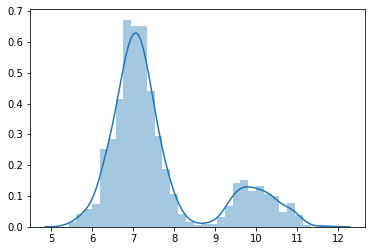

In [4]:
#Multi-Gaussian Data
#Demonstrate a model that learns the mixing proportion (delta) of two Gaussians
delta = 0.8
N = 1000
x1 = np.random.normal(7, 0.5, int((delta*N)))
x2 = np.random.normal(10, 0.5, int((1-delta)*N))
x = np.concatenate((x1, x2))
x = torch.tensor(x).float()
sns.distplot(x)

In [5]:
pyro.clear_param_store()

#A helper function for viewing model/sampling outputs
def get_params(trace):
    parameter_samples = {}
    for name, node in trace.iter_stochastic_nodes():
        if (node['type'] == 'sample' and node['is_observed'] == False):
            parameter_samples[name] = node["value"].detach()
    return parameter_samples

def model(x):
    delta = pyro.sample('delta',dist.Beta(2,2))
    changepoint = delta * len(x)
    mask = torch.arange(len(x), dtype=torch.long) >= changepoint
    dist1 = dist.Normal(7, 0.5)
    dist2 = dist.Normal(10, 0.5)
    with pyro.plate('data', len(x)):
        pyro.sample('obs', dist.MaskedMixture(mask, dist1, dist2), obs=x)
    
guide = poutine.block(model, hide_types=["is_observed"])

old_state = None

logs = []
params = []
params2 = []
params3 = []

#Basic MH 
for i in range(10000):
    
    conditioned_model = poutine.condition(model, data={"obs": x})
    new_state = poutine.trace(guide).get_trace(x)
    if i == 0:
        old_state = new_state
    
    model_tr_prop = poutine.trace(poutine.replay(conditioned_model, trace=new_state)).get_trace(x)
    model_tr_current = poutine.trace(poutine.replay(conditioned_model, trace=old_state)).get_trace(x)
    #probs = model_tr_prop
    lp1 = np.exp(model_tr_prop.log_prob_sum().detach().numpy())
    lp2 = np.exp(model_tr_current.log_prob_sum().detach().numpy())

    #log_ratio = (lp1/lp2)
    log_ratio = np.exp(model_tr_prop.log_prob_sum().detach().numpy() - model_tr_current.log_prob_sum().detach().numpy())
    logs.append(log_ratio)
    if log_ratio >= 1:
        old_state = new_state
        #print("yes")
    else:
        rand_un = torch.rand(1)
        if log_ratio > rand_un:
            old_state = new_state
        else:
            pass

    state = get_params(old_state)
    params.append(state['delta'])

/home/jberez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp


0.8003517

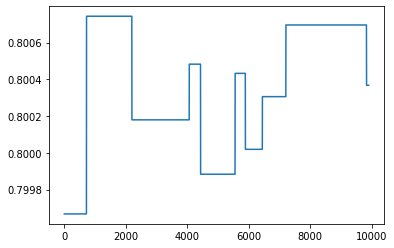

In [6]:
plt.plot(params[100:])
np.mean(params[100:])
#plt.plot(logs[400:])
#model_tr_prop

In [ ]:
pyro.clear_param_store()

def model(x, y=None):
    mu1 = pyro.sample('mu1',dist.Normal(0,10))
    beta1 = pyro.sample('beta1',dist.Normal(0,10))
    fitted = pyro.deterministic('fitted',value=(mu1 * x + beta1))
    with pyro.plate('data', len(x)):
        pyro.sample('obs', dist.Normal(fitted, 2), obs=y)

guide = poutine.block(model, hide_types=["is_observed"])

def guide(x, y=None):
    loc = torch.tensor(0).float()
    scale = torch.tensor(10).float()
    mu1l = pyro.param('mu1l',loc)
    mu1s = pyro.param('mu1s',scale)
    beta1l = pyro.param('beta1l',loc)
    beta1s = pyro.param('beta1s',scale)
    mu1 = pyro.sample('mu1', dist.Normal(mu1l, mu1s))
    beta1 = pyro.sample('beta1',dist.Normal(beta1l,beta1s))
    fitted = pyro.deterministic('fitted',value=(mu1 * x + beta1))

def get_params(trace):
    parameter_samples = {}
    for name, node in trace.iter_stochastic_nodes():
        if (node['type'] == 'sample' and node['is_observed'] == False):
            parameter_samples[name] = node["value"].detach()
    return parameter_samples

old_state = None
model(x, y)

logs = []
params = []
params2 = []
params3 = []
for i in range(40000):
    
    conditioned_model = poutine.condition(model, data={"obs": y})
    guide_tr = poutine.trace(guide).get_trace(x)
    if i == 0:
        old_state = guide_tr
    state = get_params(old_state)
    model_tr_prop = poutine.trace(poutine.replay(conditioned_model, trace=guide_tr)).get_trace(x,y)
    model_tr_current = poutine.trace(poutine.replay(conditioned_model, trace=old_state)).get_trace(x,y)
    #probs = model_tr_prop
    elbo1 = np.exp(model_tr_prop.log_prob_sum().detach().numpy()/500)
    elbo2 = np.exp(model_tr_current.log_prob_sum().detach().numpy()/500)
    #print(elbo1/elbo2)
    if elbo1/elbo2 >= 1:
        old_state = guide_tr
        logs.append(elbo1.item())
    else:
        rand_un = torch.rand(1)
        if elbo1/elbo2 > rand_un:
            old_state = guide_tr
            logs.append(elbo1.item())
        else:
            logs.append(elbo2.item())

    
    params.append(state['mu1'])
    params2.append(state['beta1'])

#plt.scatter(params,logs)
#plt.plot(params)
#print(logs)

In [ ]:
plt.plot(params)
plt.plot(params2)
#plt.plot(params3)

print(np.mean(params))
print(np.mean(params2[1000:]))
#print(np.mean(params3))
test = pyro.get_param_store()['mu1l']
print(test)

In [ ]:
plt.plot(logs)

In [ ]:
pyro.clear_param_store()
x = torch.tensor([0., 1., 10., 11., 12.])
#sns.distplot(data)

K = 2  # Fixed number of components.

#@config_enumerate
def model(data):
    # Global variables.
    weights = torch.tensor([0.5,0.5]) #pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

guide = poutine.block(model, hide_types=["is_observed"])
def guide(data):
    # Global variables.
    weights = torch.tensor([0.5,0.5]) #pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))

logs = []
params = []
params2 = []
params3 = []

for i in range(10000):
    
    conditioned_model = poutine.condition(model, data={"obs": x})
    new_state = poutine.trace(guide).get_trace(x)
    if i == 0:
        old_state = new_state
    
    model_tr_prop = poutine.trace(poutine.replay(conditioned_model, trace=new_state)).get_trace(x)
    model_tr_current = poutine.trace(poutine.replay(conditioned_model, trace=old_state)).get_trace(x)
    #probs = model_tr_prop
    lp1 = np.exp(model_tr_prop.log_prob_sum().detach().numpy())
    lp2 = np.exp(model_tr_current.log_prob_sum().detach().numpy())

    #log_ratio = (lp1/lp2)
    log_ratio = np.exp(model_tr_prop.log_prob_sum().detach().numpy() - model_tr_current.log_prob_sum().detach().numpy())
    logs.append(log_ratio)
    if log_ratio >= 1:
        old_state = new_state
        print("yes")
    else:
        rand_un = torch.rand(1)
        if log_ratio > rand_un:
            old_state = new_state
        else:
            pass

    state = get_params(old_state)
    params.append(state['components'])
    params2.append(state['assignment'])
    params3.append(state['locs'])

In [ ]:
locs1 = []
locs2 = []
for i in params3:
    locs1.append(i[0])
    locs2.append(i[1])

plt.plot(locs1)
plt.plot(locs2)

In [7]:
##################
#Reversible Jumps
##################

#Learn an Interval - Actual RJ Time
y0 = np.repeat(0, 3)
y1 = np.repeat(0.25, 7)
y2 = np.repeat(0.5, 7)
y3 = np.repeat(0.75, 3)
y4 = np.repeat(1.0, 5)

y = np.concatenate((y0, y1, y2, y3, y4))
x = [10 * ((y - 0.5) + 2)]
y = torch.tensor(y).float()
x = torch.t(torch.tensor(x).float())
print(y.size())
print(x.size())

torch.Size([25])
torch.Size([25, 1])


In [9]:
#Helper Functions
def get_params(trace):
    parameter_samples = {}
    for name, node in trace.iter_stochastic_nodes():
        if (node['type'] == 'sample' and node['is_observed'] == False):
            parameter_samples[name] = node["value"].detach()
    return parameter_samples
    
def split_k(k):
    intervals = [round(i*(float(1/k)),3) for i in range(k+1)]
    return intervals

test_k = split_k(4)
print(test_k)
print(y)

#The interval that is printed out shows the possible values based on k.
#The RJMCMC algorithm should find a distribution with high probability density at the correct value of k.

[0.0, 0.25, 0.5, 0.75, 1.0]
tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.7500,
        0.7500, 0.7500, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [12]:
#Make a very simple Bayes Net
class BNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=2):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sig1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out = self.fc1(x)
        out = nn.functional.sigmoid(out)
        out = self.fc2(out)
        out = nn.functional.sigmoid(out)
        return(out)

net = BNN()
to_pyro_module_(net)
softplus = torch.nn.Softplus()

def model(x, y):
    fc1w_prior = dist.Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight)*3)
    fc1b_prior = dist.Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias)*3)
    fc2w_prior = dist.Normal(loc=torch.zeros_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight)*3)
    fc2b_prior = dist.Normal(loc=torch.zeros_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias)*3)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior}
    lifted_module = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_module()
    lhat = lifted_reg_model(x)

    #Here is where the model must sample k
    k = 4
    interval = split_k(k)
    assignments = torch.tensor([min(interval, key=lambda x:abs(x-y)) for y in lhat]).float()

    with pyro.plate('data', len(y)):
        # Local variables.
        obs = pyro.sample('obs', dist.Normal(assignments, 0.1), obs=y)
    
    return obs

def guide(x, y):
    #First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = dist.Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = dist.Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    #Second layer weight distribution priors
    fc2w_mu = torch.randn_like(net.fc2.weight)
    fc2w_sigma = torch.randn_like(net.fc2.weight)
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2w_prior = dist.Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)
    #Second layer bias distribution priors
    fc2b_mu = torch.randn_like(net.fc2.bias)
    fc2b_sigma = torch.randn_like(net.fc2.bias)
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2b_prior = dist.Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)

    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    lifted_reg_model = lifted_module()
    lhat = lifted_reg_model(x)

    return lhat

z = model(x,y)
print(z)

tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.7500,
        0.7500, 0.7500, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [13]:
#Sampling Loop for a very basic RJMCMC (Metropolis-Hastings-Green) algorithm.
#Independent sampling, so no proposals or Jacobian term are required.
logs = []
params = []
params2 = []
params3 = []

for i in range(300):
    
    conditioned_model = poutine.condition(model, (x, y))
    new_state = poutine.trace(guide).get_trace(x, y)
    if i == 0:
        old_state = new_state
    
    model_tr_prop = poutine.trace(poutine.replay(conditioned_model, trace=new_state)).get_trace(x, y)
    model_tr_current = poutine.trace(poutine.replay(conditioned_model, trace=old_state)).get_trace(x, y)
    #probs = model_tr_prop
    lp1 = np.exp(model_tr_prop.log_prob_sum().detach().numpy())
    lp2 = np.exp(model_tr_current.log_prob_sum().detach().numpy())

    #log_ratio = (lp1/lp2)
    log_ratio = np.exp(model_tr_prop.log_prob_sum().detach().numpy() - model_tr_current.log_prob_sum().detach().numpy())
    if log_ratio > 1:
        log_ratio = 1
    logs.append(log_ratio)
    if log_ratio >= 1:
        old_state = new_state
        params.append(get_params(old_state)['module$$$fc1.weight'])
        params2.append(get_params(old_state)['module$$$fc1.bias'])
    else:
        rand_un = torch.rand(1)
        if log_ratio > rand_un:
            old_state = new_state
            params.append(get_params(old_state)['module$$$fc1.weight'])
            params2.append(get_params(old_state)['module$$$fc1.bias'])
        else:
            pass
    
    #params.append(get_params(old_state))
    #params.append(get_params(old_state)['module$$$fc1.weight'])
    #params2.append(get_params(old_state)['module$$$fc1.bias'])